# Neural Network from Scratch in Python

In [1]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
import numpy as np
from typing import List
import matplotlib.pyplot as plt

## 1 Layer, 1 Neuron Neural Network, OR logic gate
What goes on inside a perceptron?

$z = \mathbf{w} \cdot \mathbf{x} + b = w_0x_0 + w_1x_1 + b$

We introduce non-linearity to the system using the sigmoid function i.e.
$a = \sigma(z) = \frac{1}{1+e^{-z}}$

### Backpropagation
The problem regards how we actually update the weights of each neuron in the system. A common method utilises what is called the _gradient descent_ algorithm.
This involves updating the weights of each neuron, every epoch we train the model. A hyperparameter $\eta$ is introduced which is commonly called the _learning rate_ (LR) or occassionally _mixing parameter_.

$
\begin{equation}
\mathbf{w}' = \mathbf{w} - \eta \frac{\partial E}{\partial \mathbf{w}}
\end{equation}
$

We use the chain rule to solve $\frac{\partial E}{\partial \mathbf{w}}$ i.e.
$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial \mathbf{w}}
\end{equation}$

Solving each term (assuming the Error Function is MSE here and activation function is sigmoid in this case):
$\begin{equation}
\frac{\partial E}{\partial a} = \frac{\partial}{\partial a}\frac{1}{2} (y - a)^2 = a - y
\end{equation}$

$\begin{equation}
\frac{\partial a}{\partial z} = \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1 - \sigma(z))
\end{equation}$

$\begin{equation}
\frac{\partial z}{\partial \mathbf{w}} = \frac{\partial}{\partial \mathbf{w}} \mathbf{w} \cdot \mathbf{x} + b = \mathbf{x}
\end{equation}$

which finally gives us

$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = (a - y) \times \sigma(z)(1 - \sigma(z)) \times \mathbf{x}
\end{equation}$

and finally what about the bias?

$\begin{equation}
\frac{\partial E}{\partial b} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial b}
\end{equation}$

We know most of these terms except the last

$\begin{equation}
\frac{\partial z}{\partial b} = \frac{\partial}{\partial b} \mathbf{w} \cdot \mathbf{x} + b = 1
\end{equation}$

and so, finally

$\begin{equation}
\frac{\partial E}{\partial b} = (a - y) \times \sigma(z)(1 - \sigma(z))
\end{equation}$

In [2]:
class ActivationFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    @abstractmethod
    def derivative(self):
        pass

class ErrorFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    def derivative(self):
        pass

In [3]:

@dataclass
class Sigmoid(ActivationFunction):
    name: str = 'sigmoid'

    def function(self, x):
        x = np.clip(x, -500, 500 )
        return 1/(1 + np.exp(-x))
    
    def derivative(self, x):
        return self.function(x)*(1-self.function(x))
    
@dataclass 
class MeanSquaredError(ErrorFunction):
    name: str = 'MSE'

    def function(self, a, y):
        return 0.5*(y - a)**2
    
    def derivative(self, a, y):
        return (a - y)

@dataclass
class Neuron():
    input_shape: int
    activation_function: ActivationFunction
    weights: np.ndarray[np.float64] = None
    bias: float = np.random.uniform(0, 1, size=1)
    error: float = 0
    delta: np.ndarray = np.array([])
    delta_weights: np.ndarray = np.array([])
    weights_gradient = 0
    bias_gradient = 0
    z: float = None
    a: float = None
    inputs = None

    def __post_init__(self):
        """Initialise the weights. We do this post_initialisation because we depend
        on the input shape.
        """
        self.weights = np.random.uniform(-1, 1, size=self.input_shape)

    def forward(self, x: np.ndarray) -> float:
        self.inputs = np.squeeze(x)
        self.z = np.dot(self.weights, x) + self.bias
        self.a = self.activation_function.function(self.z)

        return self.a
    
    def backward(self, delta: np.ndarray):
        self.error = delta * self.activation_function.derivative(self.z)
        self.weights_gradient +=  np.outer(delta, self.inputs)
        self.bias_gradient += delta

        return self.error
    
    def update_weights(self, lr=0.05):
        self.weights -= (np.squeeze(self.weights_gradient) * lr)
        self.bias -= (self.bias_gradient * lr)

        self.weights_gradient = 0
        self.bias_gradient = 0


In [4]:
X = [[0, 0], [0, 1], [1, 0], [1, 1]]
Y = [0, 1, 1, 1]

In [5]:
n1 = Neuron(2, Sigmoid())
for x, y in zip(X, Y):
    x = np.array(x)
    y = np.array(y)

    a = n1.forward(x)
    E = 0.5*(y - a)**2
    E_prime = (a - y)

print(E_prime)

[-0.72370734]


In [6]:
n1.input_shape

2

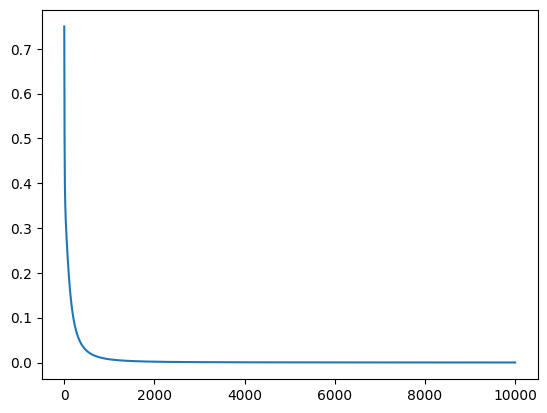

In [7]:
n1 = Neuron(2, Sigmoid())
all_E = []
for i in range(10000):
    E = 0
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a = n1.forward(x)
        E += 0.5*(y - a)**2
        E_prime = (a - y)
        delta = n1.backward(E_prime)

        n1.update_weights()
    all_E += [E]

plt.figure()
plt.plot(all_E)
plt.show()

In [8]:
n0 = Neuron(2, Sigmoid())
n1 = Neuron(1, Sigmoid())

In [9]:
w0 = n0.weights
b0 = n0.bias
w1 = n1.weights
b1 = n1.bias

lr = 0.05

for i in range(10000):
    del_w0 = 0
    del_b0 = 0
    del_w1 = 0
    del_b1 = 0
    C = 0
    for x, y in zip(X, Y):
        z0 = np.dot(x, w0) + b0
        a0 = Sigmoid().function(z0)

        z1 = np.dot(a0, w1) + b1
        a1 = Sigmoid().function(z1)

        C += 0.5*(y - a1)**2

        delta = (a1 - y) * Sigmoid().derivative(z1)
        del_w1 += np.dot(delta, np.transpose(a0))
        del_b1 += delta

        delta_0 = np.dot(np.transpose(w1), delta) * Sigmoid().derivative(z0)

        del_w0 += np.outer(delta_0, np.transpose(x))
        del_b0 += delta_0
    if np.mod(i, 1000) == 0:
        print('Epoch: %d - %f\r' % (i, C/4), end='')
    break

    w0 -= (lr/4) * np.squeeze(del_w0)
    b0 -= (lr/4) * del_b0
    w1 -= (lr/4) * del_w1
    b1 -= (lr/4) * del_b1

/var/folders/kv/lptqtxls4fxg1pdm65_wqqn80000gn/T/ipykernel_2233/3109660943.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Epoch: %d - %f\r' % (i, C/4), end='')


In [10]:
del_w1

-0.00027438559686552113

In [11]:
all_E = []
for i in range(1000):
    E = 0
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a0 = n0.forward(x)
        a1 = n1.forward(a0)
        E += 0.5*(y - a1)**2
        E_prime = (a1 - y)
        #d1 = n1.backward(E_prime)
        #d1 = E_prime * n1.activation_function.derivative(n1.z)
        #n1.delta = np.append(n1.delta, d1)
        d1 = n1.backward(E_prime)
        d0 = n0.backward(np.dot(n1.weights.T, d1))


    n1.update_weights(lr=0.5)
    n0.update_weights(lr=0.5)
    all_E += [E]


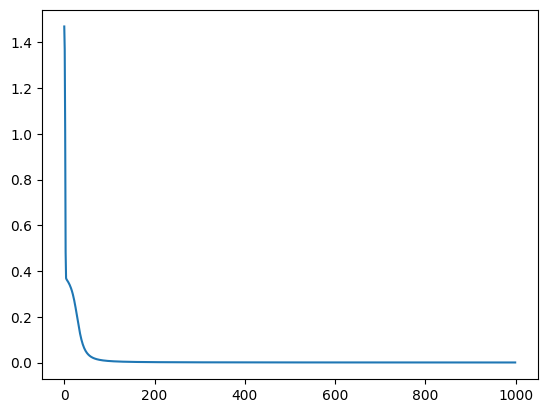

In [12]:
plt.figure()
plt.plot(all_E)
plt.show()

In [13]:
x = np.array([0, 0])
y = np.array(y)

a0 = n0.forward(x)
a1 = n1.forward(a0)

print(a1)

[0.01334217]


In [14]:
@dataclass
class Layer():
    num_neurons: int
    activation: ActivationFunction
    input_shape: np.ndarray = None
    neurons: List[Neuron] = None
    inputs: np.ndarray = None
    previous_layer: 'Layer' = None

    # Note, we make the weights a property to retain the vectorizability.
    @property
    def weights(self):
        return np.array([n.weights for n in self.neurons])
    
    @weights.setter
    def weights(self, weights):
        for w, n in zip(weights, self.neurons):
            n.weights = w

    # TODO these probably don't need to be properties
    @property
    def bias(self):
        return np.array([n.bias for n in self.neurons])
    
    @property
    def a(self):
        return np.array([n.a for n in self.neurons])
    
    @property
    def z(self):
        return np.array([n.z for n in self.neurons])
    
    @property
    def error(self):
        return np.array([n.error for n in self.neurons])
    
    @property
    def delta(self):
        return np.array([n.delta for n in self.neurons])
    
    @property
    def l_inputs(self):
        return np.array([n.inputs for n in self.neurons])

    def __post_init__(self):
        if self.input_shape is not None:
            self.initialise_layer()

    def __call__(self, layer):
        self.input_shape = layer.num_neurons
        self.initialise_layer()
        self.previous_layer = layer
        return self
    
    def initialise_layer(self):
        self.neurons = [Neuron(self.input_shape, self.activation) for _ in range(self.num_neurons)]

    def forward(self, x):
        self.inputs = x
        for n in self.neurons: n.forward(x)
        return self.a
    
    #def backward(self, error, previous_output, lp1 = None):
    #    [n.backward(error, p) for n, p in zip(self.neurons, previous_output)]
    #    if lp1 is not None:
    #        error = compute_error_term(self, lp1)
    #        return error
        
    def backward(self, error_term):
        for n, delta in zip(self.neurons, error_term): 
            n.backward(delta)

    def update_weights(self, lr=0.05):
        for n in self.neurons:
            n.update_weights(lr)

def compute_error_term(layer, layerp1):
    error = np.zeros(len(layer.neurons))
    for i in range(len(layer.neurons)):
        for j in range(len(layerp1.neurons)):
            error[i] += layerp1.neurons[j].weights[i] * layerp1.neurons[j].error # compute the dot product iteratively.
    
    return error

In [15]:
l0 = Layer(2, Sigmoid(), 2)
print(l0)
l1 = Layer(2, Sigmoid())(l0)
print(l1)
output = Layer(1, Sigmoid())(l1)
print(output)
#[n.backward(np.dot(np1.weights, np1.delta * np.ones_like(np1.weights)), a1) for n in l1.neurons for np1 in output.neurons]
#[n.backward(np.dot(np1.weights, np1.delta), a1) for n in l0.neurons for np1 in l1.neurons]
#print(output.neurons[0].delta)

Layer(num_neurons=2, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([ 0.60283188, -0.00874905]), bias=array([-4.48066795]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([ 0.80830925, -0.28607894]), bias=array([-4.48066795]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None)], inputs=None, previous_layer=None)
Layer(num_neurons=2, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.73141986, 0.11427999]), bias=array([-4.48066795]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([ 0.19775764, -0.24

In [16]:
x = np.array([1, 1])
y = np.array([1])

a0 = l0.forward(x)
a1 = l1.forward(a0)
o = output.forward(a1)

E = 0.5*(y - o)**2
print(E)
E_prime = (o - y)

[[0.4887927]]


In [17]:
a0, l1.inputs

(array([[0.02010287],
        [0.01873521]]),
 array([[0.02010287],
        [0.01873521]]))

In [18]:
output.backward(E_prime)
l1.backward(np.dot(output.weights.T, output.error))
l0.backward(np.dot(l1.weights.T, l1.error))

In [19]:
output.error

array([[-0.01101819]])

In [20]:
l0.weights

array([[ 0.60283188, -0.00874905],
       [ 0.80830925, -0.28607894]])

In [21]:
output.update_weights()
l1.update_weights()
l0.update_weights()

In [22]:
l0.weights

array([[ 0.60283539, -0.00874555],
       [ 0.80831028, -0.28607791]])

# Testing implementation

In [32]:
l0 = Layer(5, Sigmoid(), 2)
print(l0)
l1 = Layer(2, Sigmoid())(l0)
print(l1)
output = Layer(1, Sigmoid())(l1)
print(output)

Layer(num_neurons=5, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([-0.6694677 , -0.95510318]), bias=array([0.1015118]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([-0.88600212,  0.27630311]), bias=array([0.1015118]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([ 0.70026658, -0.29990807]), bias=array([0.1015118]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.54317204, 0.96747637]), bias=array([0.1015118]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None

In [33]:
all_E = []

for i in range(10000):
    epoch_E = []
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)
        a0 = l0.forward(x)
        a1 = l1.forward(a0)
        o = output.forward(a1)

        E = 0.5*(y - o)**2
        epoch_E += [E]
        E_prime = (o - y)

        output.backward(E_prime)
        l1.backward(np.dot(output.weights.T, output.error))
        l0.backward(np.dot(l1.weights.T, l1.error))
    all_E += [np.mean(epoch_E)]
    print(all_E[-1])
    
    output.update_weights(lr=0.05)
    l1.update_weights(lr = 0.05)
    l0.update_weights(lr = 0.05)

0.10786958075710068
0.10517758556922387
0.10294596158339848
0.10110845196198268
0.09960340183236623
0.09837550362222497
0.09737650509141368
0.09656519484360773
0.09590694183637054
0.09537300144469031
0.09493973537858276
0.09458783806334818
0.09430162140920183
0.09406838223094165
0.09387785921809579
0.09372177638133519
0.09359346483641377
0.093487552776661
0.09339971324507802
0.09332646001208209
0.09326498298059481
0.0932130157776201
0.09316872938937566
0.0931306467779852
0.09309757435301007
0.09306854695868176
0.09304278368889692
0.09301965237371923
0.0929986410114397
0.0929793347664026
0.0929613974301194
0.09294455646476989
0.09292859092494703
0.09291332169440208
0.09289860358683849
0.09288431894932979
0.09287037247835415
0.09285668701546314
0.092843200135185
0.09282986137423954
0.09281662998037465
0.0928034730825856
0.09279036420332457
0.09277728204846615
0.09276420952300848
0.0927511329303375
0.09273804132083913
0.0927249259620728
0.09271177990792709
0.09269859764839396
0.0926853748

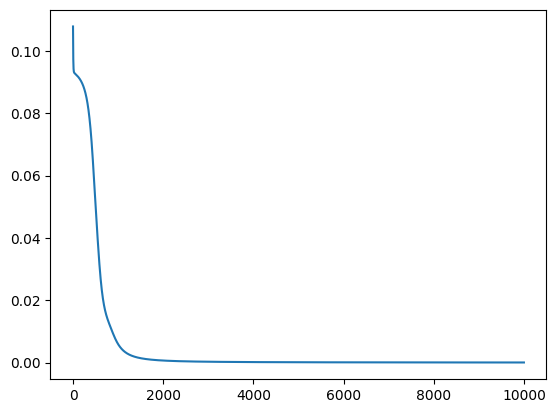

In [34]:
plt.figure()
plt.plot(all_E)
plt.show()

In [39]:
x = [1, 1]

x = np.array(x)
a0 = l0.forward(x)
a1 = l1.forward(a0)
o = output.forward(a1)

print(o)

[[0.99998439]]


# N layers

In [45]:
l0 = Layer(5, Sigmoid(), 2)
print(l0)
l1 = Layer(2, Sigmoid())(l0)
print(l1)
l2 = Layer(50, Sigmoid())(l1)
print(l2)
output = Layer(1, Sigmoid())(l2)
print(output)

Layer(num_neurons=5, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.37367263, 0.54180786]), bias=array([-4.49892702]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([ 0.72623173, -0.03795539]), bias=array([-4.49892702]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.9174002 , 0.92329196]), bias=array([-4.49892702]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.77781673, 0.94468641]), bias=array([-4.49892702]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=

In [46]:
all_E = []

for i in range(10000):
    epoch_E = []
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)
        a0 = l0.forward(x)
        a1 = l1.forward(a0)
        a2 = l2.forward(a1)
        o = output.forward(a2)

        E = 0.5*(y - o)**2
        epoch_E += [E]
        E_prime = (o - y)

        output.backward(E_prime)
        l2.backward(np.dot(output.weights.T, output.error))
        l1.backward(np.dot(l2.weights.T, l2.error))
        l0.backward(np.dot(l1.weights.T, l1.error))
    all_E += [np.mean(epoch_E)]
    print(all_E[-1])
    
    output.update_weights(lr=0.05)
    l2.update_weights(lr = 0.05)
    l1.update_weights(lr = 0.05)
    l0.update_weights(lr = 0.05)

0.36663482292426897
0.3652586219134679
0.3636471955866778
0.36175549829062
0.35952728635896114
0.35689108841870737
0.35375422640087
0.34999376952943695
0.34544258758787144
0.33986746233222936
0.3329342069354868
0.3241516046664092
0.31278210067548096
0.2977073970643358
0.2772668562656959
0.24925190619868637
0.21185914926078078
0.16753315644251993
0.12820015024343712
0.10619695021016126
0.09808131438119534
0.09550604037385509
0.09466760860927362
0.09437586967765184
0.0942657032668977
0.09421853621286003
0.09419378647604654
0.09417707262752557
0.094163205666311
0.09415030815907674
0.09413771010237976
0.09412518116867907
0.09411264847269174
0.09410009325189245
0.09408751373541707
0.09407491234324895
0.09406229165436057
0.09404965340513508
0.09403699844499822
0.0940243269314093
0.09401163853683958
0.09399893261051102
0.09398620829169457
0.09397346458505262
0.0939607004093555
0.09394791462847102
0.0939351060708805
0.09392227354188394
0.09390941583119185
0.09389653171762255
0.0938836199719895

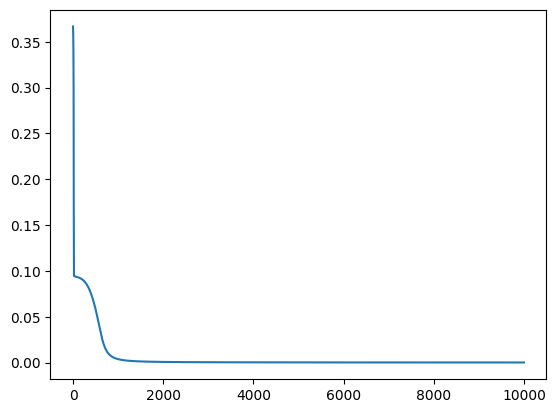

In [47]:
plt.figure()
plt.plot(all_E)
plt.show()

# MNIST Example

In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
x_train_reshaped = x_train.reshape((len(x_train), 28*28))

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

x_train_reshaped = MinMaxScaler().fit_transform(x_train_reshaped)
y_train_enc = OneHotEncoder(sparse=False).fit_transform(y_train.reshape(-1, 1))

In [ ]:
l0 = Layer(100, Sigmoid(), 28*28)
print(l0)
l1 = Layer(50, Sigmoid())(l0)
print(l1)
output = Layer(10, Sigmoid())(l1)
print(output)

In [ ]:
for x, y in zip(x_train_reshaped[0:1000, :], y_train_enc[0:1000, :]):
    break

In [ ]:
a0 = l0.forward(x)
a1 = l1.forward(a0)
o = output.forward(a1)
o = np.squeeze(o)

E = 0.5*np.sum((y - o)**2)
epoch_E += [E]
E_prime = (o - y)

output.backward(E_prime)
l1.backward(np.dot(output.weights.T, output.error))
l0.backward(np.dot(l1.weights.T, l1.error))

In [ ]:
plt.figure()
plt.plot(x * l0.neurons[50].weights + l0.neurons[50].bias)
plt.show()

In [ ]:
l0.neurons[0].weights_gradient

In [ ]:
Sigmoid().function(np.dot(l0.neurons[0].weights, x) + l0.neurons[0].bias)

In [ ]:
X

In [ ]:
np.random.choice(np.arange(len(x_train)), size=20, replace=False)

In [ ]:
from tqdm import tqdm

all_E = []
for i in range(1000):
    epoch_E = []
    idx = np.random.choice(np.arange(len(x_train)), size=64, replace=False)
    for x, y in zip(x_train_reshaped[idx], y_train_enc[idx]):
        a0 = l0.forward(x)
        a1 = l1.forward(a0)
        o = output.forward(a1)
        o = np.squeeze(o)

        E = 0.5*np.sum((y - o)**2)
        epoch_E += [E]
        E_prime = (o - y)

        output.backward(E_prime)
        l1.backward(np.dot(output.weights.T, output.error))
        l0.backward(np.dot(l1.weights.T, l1.error))
    
    output.update_weights(lr=0.05)
    l1.update_weights(lr = 0.05)
    l0.update_weights(lr = 0.05)
        
    all_E += [np.mean(epoch_E)]
    print(all_E[-1])
    
    

In [ ]:
plt.figure()
plt.plot(all_E)
plt.show()

In [ ]:
plt.figure()
plt.imshow(l0.weights[50].reshape((28, 28)))
plt.show()